# Introduction to Implementing Neural Networks from Scratch

## Generate the dataset

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [243]:
seed = 145
np.random.seed(seed)
n_samples = 300
noise = 0.2
X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)

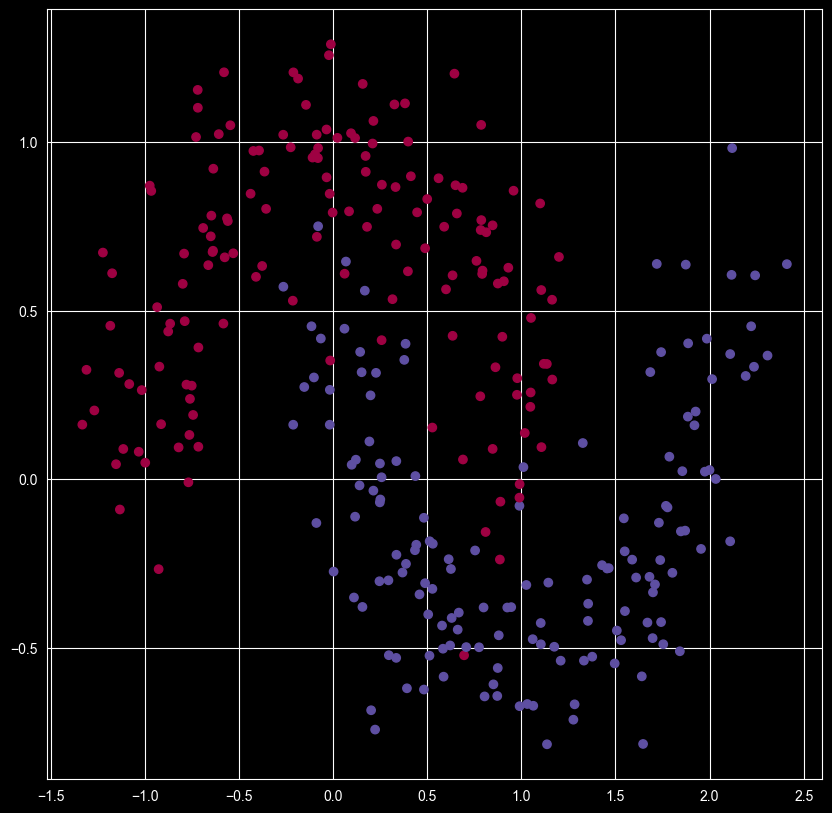

In [244]:
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

plt.show()

In [245]:
X.shape, y.shape

((300, 2), (300,))

In [246]:
# IMPORTANT: We have to reshape y to be (m, 1)
y = y.reshape(-1, 1)
X.shape, y.shape

((300, 2), (300, 1))

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [248]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 2), (60, 2), (240, 1), (60, 1))

In [249]:
# We have to transpose this to be aligned with our notation
X_train = X_train.T
y_train = y_train.reshape(1, -1)

X_test = X_test.T
y_test = y_test.reshape(1, -1)

## Implement the Neural Network

### Forward Propagation
$ Z^{[1]} = W^{[1]T}.X + b^{[1]} $ \
$ A^{[1]} = g^{[1]}(Z^{[1]}) $ \
$ Z^{[2]} = W^{[2]T}.A^{[1]} + b^{[2]} $ \
$ A^{[2]} = g^{[2]}(Z^{[2]}) = \hat{y} $

In [250]:
def initialize_randomly(input_dim, hidden_dim, output_dim):

    # Weights scaled by 0.01 to keep the values small
    W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2 / input_dim)
    b1 = np.zeros((hidden_dim, 1))

    W2 = np.random.rand(output_dim, hidden_dim)* np.sqrt(2 / hidden_dim)
    b2 = np.zeros((output_dim, 1))

    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parameters

In [251]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [252]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

In [253]:
def relu(z):
    return np.maximum(0, z)

In [254]:
def relu_derivative(z):
    return (z > 0).astype(float)

In [255]:
def forward_propagation(X, parameters, hidden_activation):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Layer 1
    Z1 = np.dot(W1, X) + b1
    A1 = hidden_activation(Z1)

    # Layer 2
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    # Set cache
    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

    return A2, cache

## Compute Cost
$ J(W1, b1, W2, b2) = - \frac{1}{m} \Sigma_{i=1}^{m} [ylog(a) + (1 - y)log(1 - a)] $

In [256]:
def compute_cost(A2, y):
    # Number of training examples
    m = y.shape[1]

    # Create a tiny epsilon to prevent log(0)
    epsilon = 1e-15

    A2 = np.clip(A2, epsilon, 1 - epsilon)

    logprobs = np.multiply(np.log(A2), y) + np.multiply(np.log(1 - A2), 1 - y)
    cost = - np.sum(logprobs) / m

    cost = float(np.squeeze(cost))

    return cost

## Backpropagation
$ dZ^{[2]} = A^{[2]} - Y $ \
$ dW^{[2]} = \frac{1}{m}dZ^{[2]}A^{[1]T} $ \
$ db^{[2]} = \frac{1}{m}\Sigma dZ^{[2]} $ \
$ dZ^{[1]} = W^{[2]T}dZ^{[2]} * g^{[1]'}(Z^{[1]})) $ \
$ dW^{[1]} = \frac{1}{m}dZ^{[2]}X^{T} $ \
$ db^{[1]} = \frac{1}{m}\Sigma dZ^{[1]} $

In [257]:
def backpropagation(parameters, cache, X, Y, g_prime=None):
    m = y.shape[1]

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    A1 = parameters['A1'] if 'A1' in parameters else cache['A1']
    A2 = cache['A2']

    Z1 = cache['Z1']

    # gradient for layer 2
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # gradient for layer 1
    # Note: (1 - np.power(A1, 2)) is the derivative of tanh
    if g_prime is None:
        dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    else:
       dZ1 = np.dot(W2.T, dZ2) * g_prime(Z1)

    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2,
    }

    return grads

In [258]:
def update_parameters(parameters, grads, learning_rate=0.01):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2,
    }

    return parameters

## Create the model to wrap everything

In [259]:
def layer_sizes(X, Y):
    n_x = X.shape[0] # Number of features
    n_h = 4          # Number of hidden units
    n_y = Y.shape[0] # Size of output layer

    return n_x, n_h, n_y

In [260]:
def nn_model(X, Y, n_h, hidden_activation, g_prime=None, num_iterations=1000, learning_rate=0.01, print_cost=False):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_randomly(n_x, n_h, n_y)
    for i in range(num_iterations):
        # Forward Propagation
        A2, cache = forward_propagation(X, parameters, hidden_activation)

        # Cost function
        cost = compute_cost(A2, Y)

        # Backpropagation
        grads = backpropagation(parameters, cache, X, Y, g_prime)

        # Gradient descent parameters update
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print(f'Cost after iteration {i + 1} is {cost}')

    return parameters

In [261]:
parameters = nn_model(X_train, y_train, n_h=4, hidden_activation=tanh, learning_rate=0.01, print_cost=True)

Cost after iteration 1 is 0.8221859517929792
Cost after iteration 101 is 0.20039840479540916
Cost after iteration 201 is 0.11956197252757414
Cost after iteration 301 is 0.10786218126144335
Cost after iteration 401 is 0.10401542807858816
Cost after iteration 501 is 0.10187738391927727
Cost after iteration 601 is 0.1004310642966571
Cost after iteration 701 is 0.09933436251391627
Cost after iteration 801 is 0.09844110133403605
Cost after iteration 901 is 0.09767847912332445


## Inference

In [262]:
def predict(parameters, X, activation):
    A2, cache = forward_propagation(X, parameters, activation)
    return (A2 > 0.5).astype(float)

In [263]:
y_pred = predict(parameters, X_test, tanh)

## Plot decision boundary

In [264]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    Z = model(grid_points)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


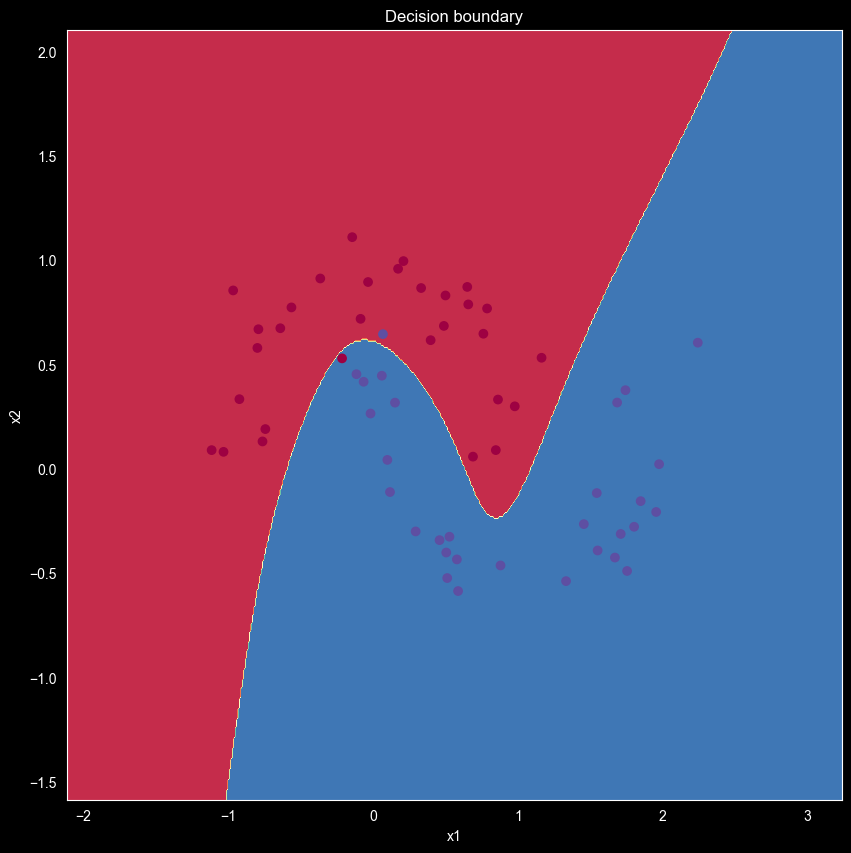

In [265]:
plt.figure(figsize=(10, 10))
plot_decision_boundary(lambda x: predict(parameters, x, tanh), X_test, y_test)
plt.title('Decision boundary')
plt.show()

## Train another model with ReLU

In [266]:
parameters = nn_model(X_train, y_train, n_h=4, hidden_activation=relu, g_prime=relu_derivative, num_iterations=10000 , learning_rate=0.005, print_cost=True)

Cost after iteration 1 is 0.706958028285534
Cost after iteration 101 is 0.27930883199300166
Cost after iteration 201 is 0.24277017716795193
Cost after iteration 301 is 0.14064882305565393
Cost after iteration 401 is 0.11673854745076453
Cost after iteration 501 is 0.10952230491386455
Cost after iteration 601 is 0.10593294216789609
Cost after iteration 701 is 0.10375786789167049
Cost after iteration 801 is 0.10225005997542755
Cost after iteration 901 is 0.10108672672200818
Cost after iteration 1001 is 0.10013115408820876
Cost after iteration 1101 is 0.09931243619082814
Cost after iteration 1201 is 0.09861362476235111
Cost after iteration 1301 is 0.0979975892158474
Cost after iteration 1401 is 0.09744484870348033
Cost after iteration 1501 is 0.096991640217002
Cost after iteration 1601 is 0.09658753691356864
Cost after iteration 1701 is 0.0962238952654125
Cost after iteration 1801 is 0.09588394408628638
Cost after iteration 1901 is 0.0955611201344702
Cost after iteration 2001 is 0.09525438

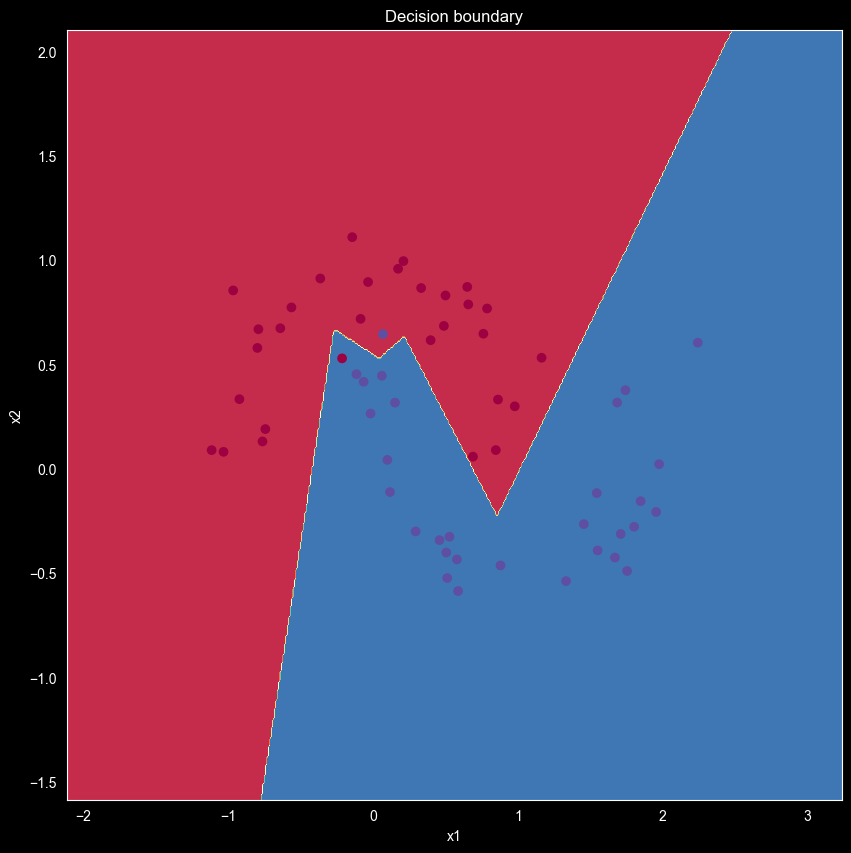

In [267]:
plt.figure(figsize=(10, 10))
plot_decision_boundary(lambda x: predict(parameters, x, relu), X_test, y_test)
plt.title('Decision boundary')
plt.show()

## Regularization
$ J_{regularized} = J_{cross-entropy} + \frac{\lambda}{2m} \Sigma_{l=1}^{L} ||W^{[l]}||^{2} $

$ dW^{[l]} = dW^{[l]}_{original} + \frac{\lambda}{m}W^{[l]} $

In [268]:
def compute_cost_regularized(A2, y, parameters, lambd):
    m = y.shape[1]

    W1 = parameters['W1']
    W2 = parameters['W2']

    # Create a tiny epsilon to prevent log(0)
    epsilon = 1e-15

    A2 = np.clip(A2, epsilon, 1 - epsilon)

    # Compute the standard Cross-Entropy loss with the previous function
    cross_entropy_loss = compute_cost(A2, y)

    L2_regularized_cost = np.sum(np.square(W1)) + np.sum(np.square(W2)) * (lambd / (2 * m))

    cost = cross_entropy_loss + L2_regularized_cost

    return float(np.squeeze(cost))

In [269]:
def backpropagation_regularized(parameters, cache, X, y, lambd, g_prime=None):
    m = y.shape[1]

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']

    # layer 2
    dZ2 = A2 - y

    # Add regularization term to dW2
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + (lambd / m) * W2
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # layer 1
    dZ1 = np.dot(W2.T, dZ2) * g_prime(Z1)

    dW1 = (1 / m) * np.dot(dZ1, X.T) + (lambd / m) * W1
    db1 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    grads = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2,
    }

    return grads

In [270]:
def nn_model_regularized(X, Y, n_h, hidden_activation, g_prime=None, num_iterations=1000, learning_rate=0.01, lambd=0.7, print_cost=False):
    np.random.seed(145)

    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_randomly(n_x, n_h, n_y)

    for i in range(num_iterations):
        # Forward
        A2, cache = forward_propagation(X, parameters, hidden_activation)

        # Cost
        cost = compute_cost_regularized(A2, Y, parameters, lambd)

        # backprop
        grads = backpropagation_regularized(parameters, cache, X, Y, lambd, g_prime)

        # Update
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print(f'Cost after iteration {i + 1} is {cost}')

    return parameters

## Train Model with Regularization

In [271]:
parameters_reg = nn_model_regularized(
    X_train, y_train,
    n_h=20,
    hidden_activation=relu,
    g_prime=relu_derivative,
    lambd=0.7,
    learning_rate=0.1,
    print_cost=True,
    num_iterations=20000
)

Cost after iteration 1 is 45.73049247236101
Cost after iteration 101 is 44.55074813319876
Cost after iteration 201 is 42.919194344548714
Cost after iteration 301 is 40.675632944070536
Cost after iteration 401 is 38.47524009645517
Cost after iteration 501 is 36.52537826921281
Cost after iteration 601 is 34.79111404993424
Cost after iteration 701 is 33.212634086102234
Cost after iteration 801 is 31.743583564787944
Cost after iteration 901 is 30.354979344063818
Cost after iteration 1001 is 29.045026293712745
Cost after iteration 1101 is 27.836278246598035
Cost after iteration 1201 is 26.72508300286143
Cost after iteration 1301 is 25.674590895504004
Cost after iteration 1401 is 24.69531623063375
Cost after iteration 1501 is 23.77756311959734
Cost after iteration 1601 is 22.894281686022477
Cost after iteration 1701 is 22.07209259347604
Cost after iteration 1801 is 21.31680890615945
Cost after iteration 1901 is 20.604492282857223
Cost after iteration 2001 is 19.952377016311857
Cost after ite

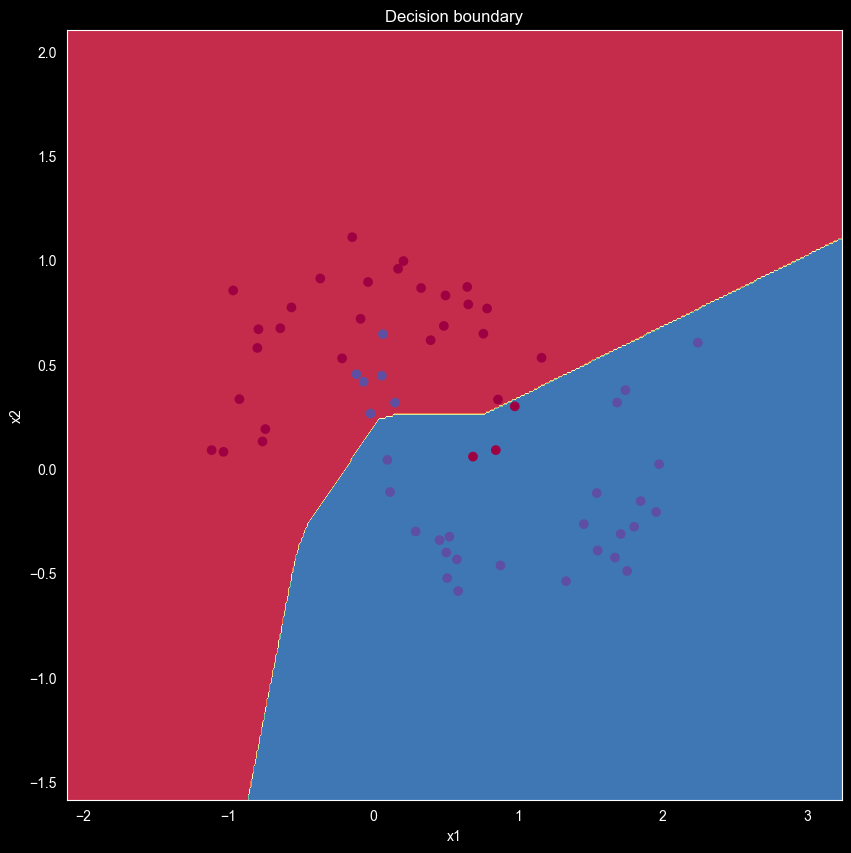

In [272]:
plt.figure(figsize=(10, 10))
plot_decision_boundary(lambda x: predict(parameters_reg, x, relu), X_test, y_test)
plt.title('Decision boundary')
plt.show()